<a href="https://colab.research.google.com/github/maahnumz/Machine-Learning-for-CyberSecurity/blob/main/lab_4_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EE 467 Lab 4: Autoencoder and Clustering

In this lab, we will continue to learn two classes of unsupervised machine learning algorithms-dimensionality reduction and clustering. These algorithms can help us figure out previously unknown patterns in the features without any kind of labels. We will apply these algorithms to the KDD Cup 1999 network intrusion dataset and visualize their results. These results may reflect differences in the characteristics of malicious and normal network connections from an alternative perspective.

## Dataset

We will work on the KDD Cup 1999 network intrusion dataset for this lab. The KDD Cup 1999 dataset consists of approximately 4.9 million records of network connections. Here a connection is a sequence of TCP packets starting and ending at some well defined times, during which data flows to and from a source IP address to a target IP address under some well defined protocol. Each connection contains 41 features and is labeled as either normal or an attack, with exactly one specific attack type. The original goal of the contest is to predictive model (i.e. a classifier) capable of distinguishing between malicious connections, called intrusions or attacks, and good normal connections.

Attacks in the KDD Cup 1999 dataset fall into four main categories:

1. DoS: Denial-of-service attacks, e.g. syn flood.
2. R2L: Unauthorized access from a remote machine, e.g. password guessing.
3. U2R: Unauthorized access to local superuser (root) privileges, e.g. privilege escalation through buffer overflow attacks.
4. Probing: surveillance and other probing, e.g. port scanning.

## Prerequisites

Before we begin, install all dependencies needed for this lab:

In [2]:
!pip install torch torchvision torchaudio

%pip install torch matplotlib numpy

Then, extract features archive we obtained from the last lab:

## Pre-processing

We have already preformed data pre-processing and dimensionality reduction in the last lab. Here, we load the `StandardScaler`-rescaled features and labels into the memory:

In [3]:
import numpy as np
from sklearn.manifold import TSNE


# Load the three arrays (no t-SNE computation here)
with np.load("./kddcup-1999-pre-processed-data.npz") as data:
    kdd_feat_std = data["kdd_feat_std"]
    kdd_feat_std_tsne = data["kdd_feat_std_tsne"]
    y_std = data["y_std"]

print("kdd_feat_std:", kdd_feat_std.shape)
print("kdd_feat_std_tsne:", kdd_feat_std_tsne.shape)
print("y_std:", y_std.shape)

kdd_feat_std: (24339, 38)
kdd_feat_std_tsne: (24339, 2)
y_std: (24339,)


Like the last lab, we continue to use `visualize_samples` function to plot transformed features in 2D space. Unless specified, we plot normal samples as green dots and malicious samples as orange dots:

Figure(1000x500)


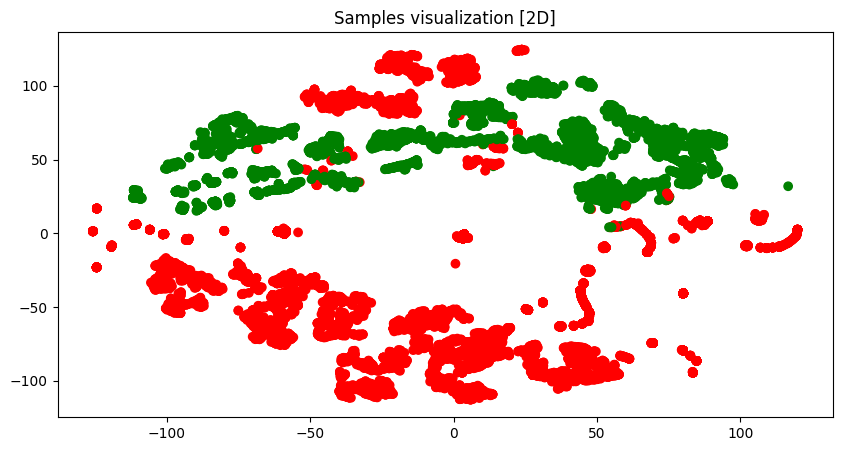

In [4]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_samples(samples, labels, title="Samples visualization", colors=["green", "red"]):
    """ Visualize first three dimensions of samples. """
    # Convert colors to NumPy array
    colors = np.array(colors)
    # Create figure
    fig = plt.figure(figsize=(10, 5))

    # 2D plot
    ax_2d = fig.add_subplot(1, 1, 1)
    ax_2d.set_title(f"{title} [2D]")
    ax_2d.scatter(samples[:, 0], samples[:, 1], c=colors[labels])

    print(fig)

# Visualize `StandardScaler` features (without dimensionality reduction)
visualize_samples(kdd_feat_std_tsne, y_std)

We will also use the following `timeit` function to monitor the training time of machine learning algorithms:

In [5]:
import time
from contextlib import contextmanager

@contextmanager
def timeit(action="Timing"):
    # Record start time
    print(f"{action} started...")
    start_time = time.time()

    # Execute task
    yield

    # Compute and show elapsed time
    elapsed_time = time.time()-start_time
    print(f"{action} completed. Elapsed time: {elapsed_time:.2f}s")

# Test timing function by sleeping for 1 second
with timeit("Testing timing function"):
    time.sleep(1)

Testing timing function started...
Testing timing function completed. Elapsed time: 1.00s


## Autoencoder

We will wrap up the introduction of dimensionality reduction algorithms with autoencoders. An **autoencoder** is a neural network used to learn a compact representation (also called encoding) for a set of data, typically for the purpose of dimensionality reduction. A typical regular autoencoder has a symmetric, five-layer structure shown below:

![autoencoder-structure.png](attachment:autoencoder-structure.png)

Like all other neural networks, the first layer is the **input layer** and the **last layer** is the output layer. For an autoencoder, the input layer and the output layer always have the same shape. We call the first three layers of the autoencoder **encoder network** and the last three layers **decoder network**. Hence, the second layer can be seen as the hidden layer of the encoder network and the fourth layer can be seen as the hidden layer of the decoder network. In practice, the shape of these layers are also made same. The third layer is the **encoder output layer**, and we make it the "bottleneck" of the autoencoder (by reducing its dimensions) so that the neural network learns to "compress" the information of previous encoder layers.

The goal of the autoencoder is to learn to **compress and reconstruct input features**, such that the **reconstruction resembles the original input** as much as possible. This forces the autoencoder to focus on the useful properties of the features and discard the noises. After training, we throw away the decoder network and use the encoder network to transform features. The result of the transformation will have fewer dimensions, yet it still preserves the characteristics and properties of the original, high-dimensional inputs.

From a formal perspective, we define the encoder transformation as $\phi: \mathcal{X} \rightarrow \mathcal{F}$ and the decoder transformation as $\psi: \mathcal{F} \rightarrow \mathcal{X}$, where $\mathcal{X}$ is the original feature space and $\mathcal{F}$ is the target feature space. Then the goal of the autoencoder is to minimize the mean-squared loss between the inputs and reconstructions:

$$
l_{AE} = ||X - \psi(\phi(X))||_2^2
$$

After training, we compute $F = \phi(X)$ to obtain target features with reduced dimensions.

Now, let's build an autoencoder in the following `make_ae_models` function. We have given you the dimensions of input features, hidden layers and the encoder output ("bottleneck") layer, as well as the activation layer type. Your task is to create an encoder and a decoder model, **both with three layers (this is different from the figure above!)**, according to the instructions in comments below. The `autoencoder_loss` function handles computation of the autoencoder (mean-squared) loss.

In [10]:
import torch
from torch import nn
from torch.nn import functional as f
from torch.utils.data import DataLoader

def get_torch_device():
    # Use CUDA (Nvidia/AMD GPU) if available
    if torch.cuda.is_available():
        device = "cuda"
    # Use MPS (Apple Silicon GPU) if available
    elif torch.backends.mps.is_available():
        device = "mps"
    # Fallback to CPU
    else:
        device = "cpu"

    return torch.device(device)


def make_ae_models(
    feat_dims, hidden_dims, bottleneck_dims,
    activation=nn.GELU, dropout_ratio=0., device="cpu"
):
    """Create and return both encoder and decoder PyTorch models."""

    # Define encoder model
    encoder_model = nn.Sequential(
        # [ TODO ]
        # Implement the encoder model to match the reference solution structure:
        #
        #   (*, feat_dims)
        #     -> Linear(feat_dims, hidden_dims)
        nn.Linear(feat_dims, hidden_dims),

        #     -> activation()
        activation(),

        #     -> Dropout(dropout_ratio)
        nn.Dropout(dropout_ratio),

        #     -> Linear(hidden_dims, bottleneck_dims)
        nn.Linear(hidden_dims, bottleneck_dims),

        #
        # Add the 4 modules below in the correct order:
        #NotImplemented,  # TODO: first Linear
        #NotImplemented,  # TODO: activation
        #NotImplemented,  # TODO: dropout
        #NotImplemented,  # TODO: bottleneck Linear
    )

    # Define decoder model

    decoder_model = nn.Sequential(
        nn.Linear(bottleneck_dims, hidden_dims),
        nn.Dropout(dropout_ratio),
        activation(),
        nn.Linear(hidden_dims, feat_dims),
        # [ TODO ]
        # Implement the decoder model to match the reference solution structure:
        #
        #   (*, bottleneck_dims)
        #     -> Linear(bottleneck_dims, hidden_dims)
        #     -> Dropout(dropout_ratio)
        #     -> activation()
        #     -> Linear(hidden_dims, feat_dims)
        #
        # Add the 4 modules below in the correct order:
        #NotImplemented,  # TODO: first Linear
        #NotImplemented,  # TODO: dropout
        #NotImplemented,  # TODO: activation
        #NotImplemented,  # TODO: output Linear
    )

    # Move models to given PyTorch device
    encoder_model = encoder_model.to(device)
    decoder_model = decoder_model.to(device)

    return encoder_model, decoder_model


def autoencoder_loss(feats, reconstructs, bottlenecks=None, l2_reg_factor=None):
    # Compute mean square error (main) loss between original and reconstructed features
    mse_loss = f.mse_loss(feats, reconstructs)

    # L2 regularization loss for bottleneck features
    if l2_reg_factor:
        l2_reg_loss = bottlenecks.square().sum(-1).mean()
        total_loss = mse_loss+l2_reg_factor*l2_reg_loss
    else:
        total_loss = mse_loss

    return total_loss, mse_loss

We then move on to the implementation of the training loop. This is a simpler version of what we did in lab 3 and homework 2 because no validation is required and thus only a single inner loop needs to be implemented.

In [11]:
from tqdm import tqdm

def train_autoencoder(encoder_model, decoder_model, optimizer, feats, n_epochs, batch_size, l2_reg_factor=0.,
    device=None):
    # Auto-detect PyTorch device from model parameters
    device = device or next(iter(encoder_model.parameters())).device
    # Make data loader for features
    loader = DataLoader(feats, batch_size, shuffle=True)

    for i in range(n_epochs):
        total_loss_epoch = 0.
        mse_loss_epoch = 0.

        print(f"Starting training epoch {i+1}/{n_epochs} ...")

        for feats_batch in tqdm(loader):
            feats_batch = feats.to(device)

            # Forward features through both encoder and decoder,
            # saving bottleneck and reconstructed features in the process
            bottlenecks = encoder_model(feats_batch)
            reconstructs = decoder_model(bottlenecks)
            # Compute autoencoder loss
            total_loss_batch, mse_loss_batch = autoencoder_loss(
                feats_batch, reconstructs, bottlenecks, l2_reg_factor
            )

            # Run an optimizer step
            total_loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Collect statistics
            total_loss_epoch += total_loss_batch.detach().cpu()
            mse_loss_epoch += mse_loss_batch.detach().cpu()

        total_loss_epoch /= len(loader)
        mse_loss_epoch /= len(loader)

        print(f"Training of epoch {i+1}/{n_epochs}: Total loss: {total_loss_epoch.item()}, MSE loss: {mse_loss_epoch.item()}")

Alright, we now have all the components we need to train an autoencoder, and then use it to reduce the dimensionality of our `StandardScaler` features (`kdd_feat_std_tensor`). We will perform these steps, and once we get the bottleneck features from our encoder model, we can visualize them through 2D and 3D plots:

Starting training epoch 1/50 ...


100%|██████████| 96/96 [00:00<00:00, 134.40it/s]


Training of epoch 1/50: Total loss: 0.14556215703487396, MSE loss: 0.14556215703487396
Starting training epoch 2/50 ...


100%|██████████| 96/96 [00:00<00:00, 415.00it/s]


Training of epoch 2/50: Total loss: 0.025998003780841827, MSE loss: 0.025998003780841827
Starting training epoch 3/50 ...


100%|██████████| 96/96 [00:00<00:00, 418.17it/s]


Training of epoch 3/50: Total loss: 0.012086506932973862, MSE loss: 0.012086506932973862
Starting training epoch 4/50 ...


100%|██████████| 96/96 [00:00<00:00, 401.57it/s]


Training of epoch 4/50: Total loss: 0.00772269070148468, MSE loss: 0.00772269070148468
Starting training epoch 5/50 ...


100%|██████████| 96/96 [00:00<00:00, 419.53it/s]


Training of epoch 5/50: Total loss: 0.005576005205512047, MSE loss: 0.005576005205512047
Starting training epoch 6/50 ...


100%|██████████| 96/96 [00:00<00:00, 410.83it/s]


Training of epoch 6/50: Total loss: 0.004415756091475487, MSE loss: 0.004415756091475487
Starting training epoch 7/50 ...


100%|██████████| 96/96 [00:00<00:00, 405.81it/s]


Training of epoch 7/50: Total loss: 0.0038105370476841927, MSE loss: 0.0038105370476841927
Starting training epoch 8/50 ...


100%|██████████| 96/96 [00:00<00:00, 405.09it/s]


Training of epoch 8/50: Total loss: 0.0034352438524365425, MSE loss: 0.0034352438524365425
Starting training epoch 9/50 ...


100%|██████████| 96/96 [00:00<00:00, 429.73it/s]


Training of epoch 9/50: Total loss: 0.003116556443274021, MSE loss: 0.003116556443274021
Starting training epoch 10/50 ...


100%|██████████| 96/96 [00:00<00:00, 425.96it/s]


Training of epoch 10/50: Total loss: 0.002910279668867588, MSE loss: 0.002910279668867588
Starting training epoch 11/50 ...


100%|██████████| 96/96 [00:00<00:00, 426.42it/s]


Training of epoch 11/50: Total loss: 0.0027207275852560997, MSE loss: 0.0027207275852560997
Starting training epoch 12/50 ...


100%|██████████| 96/96 [00:00<00:00, 418.64it/s]


Training of epoch 12/50: Total loss: 0.0025644891429692507, MSE loss: 0.0025644891429692507
Starting training epoch 13/50 ...


100%|██████████| 96/96 [00:00<00:00, 411.86it/s]


Training of epoch 13/50: Total loss: 0.002469022758305073, MSE loss: 0.002469022758305073
Starting training epoch 14/50 ...


100%|██████████| 96/96 [00:00<00:00, 418.81it/s]


Training of epoch 14/50: Total loss: 0.0023452790919691324, MSE loss: 0.0023452790919691324
Starting training epoch 15/50 ...


100%|██████████| 96/96 [00:00<00:00, 414.37it/s]


Training of epoch 15/50: Total loss: 0.0022830753587186337, MSE loss: 0.0022830753587186337
Starting training epoch 16/50 ...


100%|██████████| 96/96 [00:00<00:00, 412.20it/s]


Training of epoch 16/50: Total loss: 0.0021556743886321783, MSE loss: 0.0021556743886321783
Starting training epoch 17/50 ...


100%|██████████| 96/96 [00:00<00:00, 395.76it/s]


Training of epoch 17/50: Total loss: 0.0020613970700651407, MSE loss: 0.0020613970700651407
Starting training epoch 18/50 ...


100%|██████████| 96/96 [00:00<00:00, 415.26it/s]


Training of epoch 18/50: Total loss: 0.0019513275474309921, MSE loss: 0.0019513275474309921
Starting training epoch 19/50 ...


100%|██████████| 96/96 [00:00<00:00, 410.88it/s]


Training of epoch 19/50: Total loss: 0.0018560654716566205, MSE loss: 0.0018560654716566205
Starting training epoch 20/50 ...


100%|██████████| 96/96 [00:00<00:00, 408.91it/s]


Training of epoch 20/50: Total loss: 0.0017955995863303542, MSE loss: 0.0017955995863303542
Starting training epoch 21/50 ...


100%|██████████| 96/96 [00:00<00:00, 403.85it/s]


Training of epoch 21/50: Total loss: 0.0017266188515350223, MSE loss: 0.0017266188515350223
Starting training epoch 22/50 ...


100%|██████████| 96/96 [00:00<00:00, 420.33it/s]


Training of epoch 22/50: Total loss: 0.001660838839598, MSE loss: 0.001660838839598
Starting training epoch 23/50 ...


100%|██████████| 96/96 [00:00<00:00, 368.52it/s]


Training of epoch 23/50: Total loss: 0.0016232565976679325, MSE loss: 0.0016232565976679325
Starting training epoch 24/50 ...


100%|██████████| 96/96 [00:00<00:00, 308.17it/s]


Training of epoch 24/50: Total loss: 0.0015601860359311104, MSE loss: 0.0015601860359311104
Starting training epoch 25/50 ...


100%|██████████| 96/96 [00:00<00:00, 317.79it/s]


Training of epoch 25/50: Total loss: 0.0015131332911550999, MSE loss: 0.0015131332911550999
Starting training epoch 26/50 ...


100%|██████████| 96/96 [00:00<00:00, 326.94it/s]


Training of epoch 26/50: Total loss: 0.001421249471604824, MSE loss: 0.001421249471604824
Starting training epoch 27/50 ...


100%|██████████| 96/96 [00:00<00:00, 311.15it/s]


Training of epoch 27/50: Total loss: 0.001392223290167749, MSE loss: 0.001392223290167749
Starting training epoch 28/50 ...


100%|██████████| 96/96 [00:00<00:00, 301.35it/s]


Training of epoch 28/50: Total loss: 0.0013457178138196468, MSE loss: 0.0013457178138196468
Starting training epoch 29/50 ...


100%|██████████| 96/96 [00:00<00:00, 268.86it/s]


Training of epoch 29/50: Total loss: 0.0012920096050947905, MSE loss: 0.0012920096050947905
Starting training epoch 30/50 ...


100%|██████████| 96/96 [00:00<00:00, 362.82it/s]


Training of epoch 30/50: Total loss: 0.0012713097967207432, MSE loss: 0.0012713097967207432
Starting training epoch 31/50 ...


100%|██████████| 96/96 [00:00<00:00, 405.80it/s]


Training of epoch 31/50: Total loss: 0.0012318004155531526, MSE loss: 0.0012318004155531526
Starting training epoch 32/50 ...


100%|██████████| 96/96 [00:00<00:00, 393.33it/s]


Training of epoch 32/50: Total loss: 0.0012134603457525373, MSE loss: 0.0012134603457525373
Starting training epoch 33/50 ...


100%|██████████| 96/96 [00:00<00:00, 410.79it/s]


Training of epoch 33/50: Total loss: 0.001190456678159535, MSE loss: 0.001190456678159535
Starting training epoch 34/50 ...


100%|██████████| 96/96 [00:00<00:00, 407.32it/s]


Training of epoch 34/50: Total loss: 0.0011990696657449007, MSE loss: 0.0011990696657449007
Starting training epoch 35/50 ...


100%|██████████| 96/96 [00:00<00:00, 405.23it/s]


Training of epoch 35/50: Total loss: 0.0011319469194859266, MSE loss: 0.0011319469194859266
Starting training epoch 36/50 ...


100%|██████████| 96/96 [00:00<00:00, 412.20it/s]


Training of epoch 36/50: Total loss: 0.0011440700618550181, MSE loss: 0.0011440700618550181
Starting training epoch 37/50 ...


100%|██████████| 96/96 [00:00<00:00, 399.46it/s]


Training of epoch 37/50: Total loss: 0.0011048003798350692, MSE loss: 0.0011048003798350692
Starting training epoch 38/50 ...


100%|██████████| 96/96 [00:00<00:00, 397.89it/s]


Training of epoch 38/50: Total loss: 0.0011068368330597878, MSE loss: 0.0011068368330597878
Starting training epoch 39/50 ...


100%|██████████| 96/96 [00:00<00:00, 407.12it/s]


Training of epoch 39/50: Total loss: 0.0010441598715260625, MSE loss: 0.0010441598715260625
Starting training epoch 40/50 ...


100%|██████████| 96/96 [00:00<00:00, 414.07it/s]


Training of epoch 40/50: Total loss: 0.0010353310499340296, MSE loss: 0.0010353310499340296
Starting training epoch 41/50 ...


100%|██████████| 96/96 [00:00<00:00, 395.08it/s]


Training of epoch 41/50: Total loss: 0.0010076025500893593, MSE loss: 0.0010076025500893593
Starting training epoch 42/50 ...


100%|██████████| 96/96 [00:00<00:00, 409.81it/s]


Training of epoch 42/50: Total loss: 0.0009830498602241278, MSE loss: 0.0009830498602241278
Starting training epoch 43/50 ...


100%|██████████| 96/96 [00:00<00:00, 408.39it/s]


Training of epoch 43/50: Total loss: 0.0009782429551705718, MSE loss: 0.0009782429551705718
Starting training epoch 44/50 ...


100%|██████████| 96/96 [00:00<00:00, 359.82it/s]


Training of epoch 44/50: Total loss: 0.0009340458200313151, MSE loss: 0.0009340458200313151
Starting training epoch 45/50 ...


100%|██████████| 96/96 [00:00<00:00, 391.56it/s]


Training of epoch 45/50: Total loss: 0.0009266636334359646, MSE loss: 0.0009266636334359646
Starting training epoch 46/50 ...


100%|██████████| 96/96 [00:00<00:00, 409.03it/s]


Training of epoch 46/50: Total loss: 0.0009225965477526188, MSE loss: 0.0009225965477526188
Starting training epoch 47/50 ...


100%|██████████| 96/96 [00:00<00:00, 403.28it/s]


Training of epoch 47/50: Total loss: 0.0008912620251066983, MSE loss: 0.0008912620251066983
Starting training epoch 48/50 ...


100%|██████████| 96/96 [00:00<00:00, 417.54it/s]


Training of epoch 48/50: Total loss: 0.0008909172029234469, MSE loss: 0.0008909172029234469
Starting training epoch 49/50 ...


100%|██████████| 96/96 [00:00<00:00, 405.98it/s]


Training of epoch 49/50: Total loss: 0.0008676297147758305, MSE loss: 0.0008676297147758305
Starting training epoch 50/50 ...


100%|██████████| 96/96 [00:00<00:00, 409.31it/s]


Training of epoch 50/50: Total loss: 0.0008718205499462783, MSE loss: 0.0008718205499462783
Figure(1000x500)


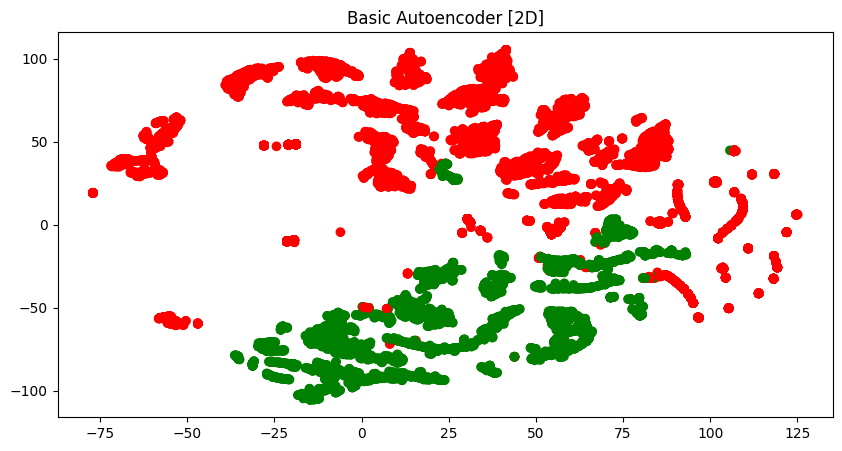

In [12]:
from itertools import chain

from torch.optim import AdamW

# Get preferred PyTorch device
torch_device = get_torch_device()
# Convert `kdd_feat_std` to PyTorch tensor, and put tensor on selected device
kdd_feat_std_tensor = torch.tensor(kdd_feat_std, device=torch_device, dtype=torch.float32)

# Make basic autoencoder models
enc_model_1, dec_model_1 = make_ae_models(
    feat_dims=kdd_feat_std.shape[1],
    hidden_dims=20,
    bottleneck_dims=10,
    device=torch_device
)
# Create optimizer for autoencoder models
optimizer = AdamW(
    chain(enc_model_1.parameters(), dec_model_1.parameters()),
    lr=0.005
)

# Train basic autoencoder models
train_autoencoder(
    enc_model_1, dec_model_1, optimizer, kdd_feat_std_tensor, n_epochs=50, batch_size=256
)
# Perform dimensionality reduction with the encoder
with torch.inference_mode():
    kdd_feat_ae_1 = enc_model_1(kdd_feat_std_tensor)
    kdd_feat_ae_1 = kdd_feat_ae_1.cpu().numpy()

# Run 2D t-SNE on StandardScaler features
autoenc_tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42,
)

kdd_feat_ae_1_tsne = autoenc_tsne.fit_transform(kdd_feat_ae_1)

# Plot basic autoencoder bottleneck features
visualize_samples(kdd_feat_ae_1_tsne, y_std, title="Basic Autoencoder")

Now that we have successfully trained our first autoencoder and transformed `StandardScaler` features to 10D space, we can try a few measures to improve it. First, we are going to **increase the capacity of the hidden layers** of our autoencoder. However, simply enlarging linear layers could make the autoencoder training more likely to overfit. Thus, we will **apply dropout** for the encoder and the decoder each. Another possible mitigation for the overfitting issue is **regularization**, which we will add to the encoder output so that the autoencoder loss becomes:

$$
l_{AE-L2} = ||X - \psi(\phi(X))||_2^2 + \lambda ||\phi(X)||_2^2
$$

To apply these improvements, go back to the `make_ae_models` function, then add [`torch.nn.Dropout`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layers between existing linear and activation layers. The L2 regularization is already implemented in `autoencoder_loss`, and you can enable it by forwarding the `l2_reg_factor` parameter for your `train_autoencoder` function. Finally, play with the hidden layer sizes, dropout ratio and L2 output regularization strength to see how the output features generated by the enhanced autoencoder actually look like.

Starting training epoch 1/50 ...


100%|██████████| 96/96 [00:00<00:00, 214.27it/s]


Training of epoch 1/50: Total loss: 0.1215461865067482, MSE loss: 0.11732398718595505
Starting training epoch 2/50 ...


100%|██████████| 96/96 [00:00<00:00, 366.43it/s]


Training of epoch 2/50: Total loss: 0.04146819934248924, MSE loss: 0.03928788751363754
Starting training epoch 3/50 ...


100%|██████████| 96/96 [00:00<00:00, 368.40it/s]


Training of epoch 3/50: Total loss: 0.03280641511082649, MSE loss: 0.03125337138772011
Starting training epoch 4/50 ...


100%|██████████| 96/96 [00:00<00:00, 370.29it/s]


Training of epoch 4/50: Total loss: 0.02970230020582676, MSE loss: 0.02847188524901867
Starting training epoch 5/50 ...


100%|██████████| 96/96 [00:00<00:00, 351.91it/s]


Training of epoch 5/50: Total loss: 0.02780306339263916, MSE loss: 0.02676134742796421
Starting training epoch 6/50 ...


100%|██████████| 96/96 [00:00<00:00, 369.00it/s]


Training of epoch 6/50: Total loss: 0.026746565476059914, MSE loss: 0.025830818340182304
Starting training epoch 7/50 ...


100%|██████████| 96/96 [00:00<00:00, 356.95it/s]


Training of epoch 7/50: Total loss: 0.026006070896983147, MSE loss: 0.02518627978861332
Starting training epoch 8/50 ...


100%|██████████| 96/96 [00:00<00:00, 362.85it/s]


Training of epoch 8/50: Total loss: 0.025428324937820435, MSE loss: 0.024668307974934578
Starting training epoch 9/50 ...


100%|██████████| 96/96 [00:00<00:00, 349.40it/s]


Training of epoch 9/50: Total loss: 0.025173502042889595, MSE loss: 0.02446330524981022
Starting training epoch 10/50 ...


100%|██████████| 96/96 [00:00<00:00, 366.32it/s]


Training of epoch 10/50: Total loss: 0.02493300288915634, MSE loss: 0.02425895445048809
Starting training epoch 11/50 ...


100%|██████████| 96/96 [00:00<00:00, 364.95it/s]


Training of epoch 11/50: Total loss: 0.024630285799503326, MSE loss: 0.02398577146232128
Starting training epoch 12/50 ...


100%|██████████| 96/96 [00:00<00:00, 363.06it/s]


Training of epoch 12/50: Total loss: 0.024526001885533333, MSE loss: 0.0239056795835495
Starting training epoch 13/50 ...


100%|██████████| 96/96 [00:00<00:00, 347.77it/s]


Training of epoch 13/50: Total loss: 0.024234989657998085, MSE loss: 0.02364339679479599
Starting training epoch 14/50 ...


100%|██████████| 96/96 [00:00<00:00, 368.09it/s]


Training of epoch 14/50: Total loss: 0.024034900590777397, MSE loss: 0.02346544899046421
Starting training epoch 15/50 ...


100%|██████████| 96/96 [00:00<00:00, 368.33it/s]


Training of epoch 15/50: Total loss: 0.024172885343432426, MSE loss: 0.02362298220396042
Starting training epoch 16/50 ...


100%|██████████| 96/96 [00:00<00:00, 364.03it/s]


Training of epoch 16/50: Total loss: 0.02373828925192356, MSE loss: 0.023190662264823914
Starting training epoch 17/50 ...


100%|██████████| 96/96 [00:00<00:00, 351.85it/s]


Training of epoch 17/50: Total loss: 0.023596568033099174, MSE loss: 0.023076852783560753
Starting training epoch 18/50 ...


100%|██████████| 96/96 [00:00<00:00, 368.85it/s]


Training of epoch 18/50: Total loss: 0.023633858188986778, MSE loss: 0.023132430389523506
Starting training epoch 19/50 ...


100%|██████████| 96/96 [00:00<00:00, 360.66it/s]


Training of epoch 19/50: Total loss: 0.023533619940280914, MSE loss: 0.023043783381581306
Starting training epoch 20/50 ...


100%|██████████| 96/96 [00:00<00:00, 326.28it/s]


Training of epoch 20/50: Total loss: 0.023530064150691032, MSE loss: 0.023041538894176483
Starting training epoch 21/50 ...


100%|██████████| 96/96 [00:00<00:00, 361.87it/s]


Training of epoch 21/50: Total loss: 0.023258650675415993, MSE loss: 0.02279069274663925
Starting training epoch 22/50 ...


100%|██████████| 96/96 [00:00<00:00, 361.97it/s]


Training of epoch 22/50: Total loss: 0.02334435097873211, MSE loss: 0.022889578714966774
Starting training epoch 23/50 ...


100%|██████████| 96/96 [00:00<00:00, 361.50it/s]


Training of epoch 23/50: Total loss: 0.0232843067497015, MSE loss: 0.02283419854938984
Starting training epoch 24/50 ...


100%|██████████| 96/96 [00:00<00:00, 351.15it/s]


Training of epoch 24/50: Total loss: 0.023186424747109413, MSE loss: 0.022732989862561226
Starting training epoch 25/50 ...


100%|██████████| 96/96 [00:00<00:00, 294.04it/s]


Training of epoch 25/50: Total loss: 0.022967400029301643, MSE loss: 0.022535279393196106
Starting training epoch 26/50 ...


100%|██████████| 96/96 [00:00<00:00, 268.40it/s]


Training of epoch 26/50: Total loss: 0.022889738902449608, MSE loss: 0.022467149421572685
Starting training epoch 27/50 ...


100%|██████████| 96/96 [00:00<00:00, 278.61it/s]


Training of epoch 27/50: Total loss: 0.02283514477312565, MSE loss: 0.022420188412070274
Starting training epoch 28/50 ...


100%|██████████| 96/96 [00:00<00:00, 292.14it/s]


Training of epoch 28/50: Total loss: 0.023002395406365395, MSE loss: 0.02259715087711811
Starting training epoch 29/50 ...


100%|██████████| 96/96 [00:00<00:00, 257.13it/s]


Training of epoch 29/50: Total loss: 0.022638222202658653, MSE loss: 0.02223161794245243
Starting training epoch 30/50 ...


100%|██████████| 96/96 [00:00<00:00, 250.78it/s]


Training of epoch 30/50: Total loss: 0.022708311676979065, MSE loss: 0.022312326356768608
Starting training epoch 31/50 ...


100%|██████████| 96/96 [00:00<00:00, 318.93it/s]


Training of epoch 31/50: Total loss: 0.02276989258825779, MSE loss: 0.02237756736576557
Starting training epoch 32/50 ...


100%|██████████| 96/96 [00:00<00:00, 362.51it/s]


Training of epoch 32/50: Total loss: 0.02249997667968273, MSE loss: 0.022114478051662445
Starting training epoch 33/50 ...


100%|██████████| 96/96 [00:00<00:00, 359.96it/s]


Training of epoch 33/50: Total loss: 0.022617898881435394, MSE loss: 0.02223818562924862
Starting training epoch 34/50 ...


100%|██████████| 96/96 [00:00<00:00, 352.61it/s]


Training of epoch 34/50: Total loss: 0.0226201880723238, MSE loss: 0.022246070206165314
Starting training epoch 35/50 ...


100%|██████████| 96/96 [00:00<00:00, 361.90it/s]


Training of epoch 35/50: Total loss: 0.022518491372466087, MSE loss: 0.022151274606585503
Starting training epoch 36/50 ...


100%|██████████| 96/96 [00:00<00:00, 359.04it/s]


Training of epoch 36/50: Total loss: 0.02253575064241886, MSE loss: 0.022170567885041237
Starting training epoch 37/50 ...


100%|██████████| 96/96 [00:00<00:00, 360.79it/s]


Training of epoch 37/50: Total loss: 0.022528037428855896, MSE loss: 0.02216719649732113
Starting training epoch 38/50 ...


100%|██████████| 96/96 [00:00<00:00, 345.18it/s]


Training of epoch 38/50: Total loss: 0.022520674392580986, MSE loss: 0.02216316945850849
Starting training epoch 39/50 ...


100%|██████████| 96/96 [00:00<00:00, 359.99it/s]


Training of epoch 39/50: Total loss: 0.022372910752892494, MSE loss: 0.022018523886799812
Starting training epoch 40/50 ...


100%|██████████| 96/96 [00:00<00:00, 354.66it/s]


Training of epoch 40/50: Total loss: 0.022334182634949684, MSE loss: 0.02198200114071369
Starting training epoch 41/50 ...


100%|██████████| 96/96 [00:00<00:00, 363.12it/s]


Training of epoch 41/50: Total loss: 0.02241521328687668, MSE loss: 0.02206897921860218
Starting training epoch 42/50 ...


100%|██████████| 96/96 [00:00<00:00, 347.64it/s]


Training of epoch 42/50: Total loss: 0.022260375320911407, MSE loss: 0.021915266290307045
Starting training epoch 43/50 ...


100%|██████████| 96/96 [00:00<00:00, 361.59it/s]


Training of epoch 43/50: Total loss: 0.022305084392428398, MSE loss: 0.02196287363767624
Starting training epoch 44/50 ...


100%|██████████| 96/96 [00:00<00:00, 355.43it/s]


Training of epoch 44/50: Total loss: 0.0224111657589674, MSE loss: 0.022071532905101776
Starting training epoch 45/50 ...


100%|██████████| 96/96 [00:00<00:00, 349.40it/s]


Training of epoch 45/50: Total loss: 0.022344840690493584, MSE loss: 0.022008219733834267
Starting training epoch 46/50 ...


100%|██████████| 96/96 [00:00<00:00, 360.46it/s]


Training of epoch 46/50: Total loss: 0.022259904071688652, MSE loss: 0.021925272420048714
Starting training epoch 47/50 ...


100%|██████████| 96/96 [00:00<00:00, 359.33it/s]


Training of epoch 47/50: Total loss: 0.02235223352909088, MSE loss: 0.022021180018782616
Starting training epoch 48/50 ...


100%|██████████| 96/96 [00:00<00:00, 364.86it/s]


Training of epoch 48/50: Total loss: 0.022193290293216705, MSE loss: 0.02185879461467266
Starting training epoch 49/50 ...


100%|██████████| 96/96 [00:00<00:00, 354.52it/s]


Training of epoch 49/50: Total loss: 0.022179575636982918, MSE loss: 0.021851954981684685
Starting training epoch 50/50 ...


100%|██████████| 96/96 [00:00<00:00, 362.93it/s]


Training of epoch 50/50: Total loss: 0.022314103320240974, MSE loss: 0.021990634500980377
Figure(1000x500)


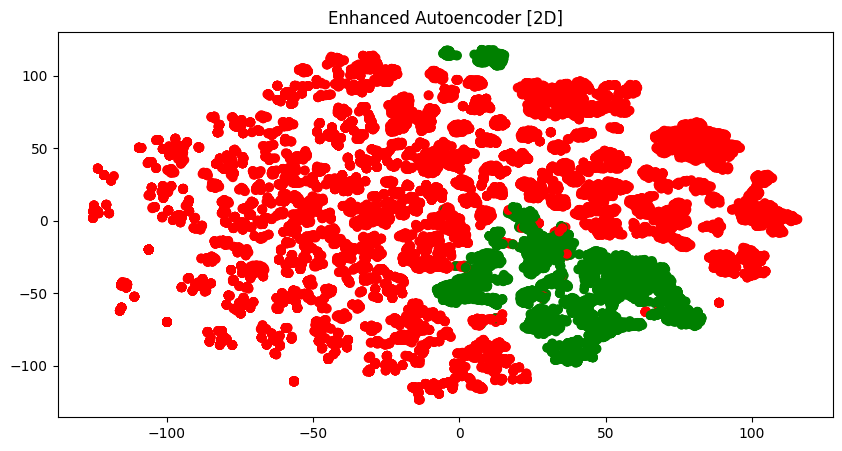

In [13]:
# [ TODO ]
# Make enhanced autoencoder models with the following improvements:
# 1) Increased hidden layer capacity (`hidden_dims=25`)
# 2) Enable dropout to prevent over-fitting (`dropout_ratio=0.1`)
#
# NOTE: Use feat_dims=kdd_feat_std.shape[1] and device=torch_device
#enc_model_2, dec_model_2 = NotImplemented
enc_model_2, dec_model_2 = make_ae_models(
    feat_dims=kdd_feat_std.shape[1],
    hidden_dims=25,
    bottleneck_dims=10,
    dropout_ratio=0.1,
    device=torch_device
)


# Create optimizer for autoencoder models (fixed learning rate)
optimizer = AdamW(
    chain(enc_model_2.parameters(), dec_model_2.parameters()),
    lr=0.01
)

# Train enhanced autoencoder models
# Enable L2 regularization of decoder output (bottleneck features) using:
train_autoencoder(
    enc_model_2, dec_model_2, optimizer, kdd_feat_std_tensor,
    n_epochs=50, batch_size=256,
    l2_reg_factor=0.001
)

# Perform dimensionality reduction with the encoder
with torch.inference_mode():
    kdd_feat_ae_2 = enc_model_2(kdd_feat_std_tensor)
    kdd_feat_ae_2 = kdd_feat_ae_2.cpu().numpy()

# [ TODO ]
# Run 2D t-SNE on the *autoencoder bottleneck features* (kdd_feat_ae_2) using:
# - n_components=2
# - perplexity=30
# - learning_rate="auto"
# - init="pca"
#
# Then:
# - fit_transform kdd_feat_ae_2
# - store result in kdd_feat_ae_2_tsne
#kdd_feat_ae_2_tsne = NotImplemented
autoenc2_tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42,
)
kdd_feat_ae_2_tsne = autoenc2_tsne.fit_transform(kdd_feat_ae_2)


# Plot enhanced autoencoder bottleneck features (2D tsne)
visualize_samples(kdd_feat_ae_2_tsne, y_std, title="Enhanced Autoencoder")

## Clustering

The second part of this lab involves clustering analysis, or simply **clustering**. It is the task of grouping samples into multiple groups (called **clusters**) such that samples within the same group are more similar than samples from different groups. Clustering algorithms are **unsupervised learning** algorithms because grouping is solely based on the features, without the need of any labels, though you will see in the later part of this lab that labels can help evaluate clustering result.

Like the previous lab, a few utility functions are required to compute metrics for clustering result. The first one is `confusion_matrix`, which does exactly the same thing as `sklearn.metrics.confusion_matrix`, except it allows different number of classes in predictions and true labels. This makes it handy for clustering result because the number of clusters may not necessarily equal to the number of true classes.

In [14]:
def confusion_matrix(actuals, preds):
    """ Extension of `sklearn.metrics.confusion_matrix`, suitable for clustering results. """
    # Number of classes of predictions and true labels
    n_classes_actual = max(actuals)+1
    n_classes_pred = max(preds)+1
    # Confusion matrix
    matrix = np.zeros((n_classes_pred, n_classes_actual), dtype=int)

    # Update matrix count for each sample
    for pred, actual in zip(preds, actuals):
        matrix[pred][actual] += 1

    return matrix

The second function computes the overall entropy of clustering result, when the true labels are available. Assume we have $c$ classes and $k$ clusters $\Omega = {\omega_1, \dots, \omega_k}$, the in-cluster entropy for cluster $i$ can be computed by:

$$
H(\omega_i) = -\sum_{j=1}^c \frac{|\omega_{ij}|}{|\omega_i|} \log \frac{|\omega_{ij}|}{|\omega_i|}
$$

where $\omega_{ij}$ represents samples that belong to both cluster $i$ and class $j$. The overall entropy of clustering result, which is the weighted average of in-cluster entropy, can then be computed as:

$$
H(\Omega) = \sum_{i=1}^k \frac{|\omega_i|}{|\Omega|} H(\omega_i)
$$

Later you will see that the overall entropy of clustering result is a good metric to determine the amount of clusters.

In [15]:
# Epsilon for entropy computation
EPSILON = 0.01

def clustering_entropy(conf_matrix):
    """ Compute the entropy of classification result. """
    zero_items = conf_matrix==0
    # Add an epsilon to zero elements in confusion matrix
    if zero_items.any():
        conf_matrix = conf_matrix.astype(float)
        conf_matrix[zero_items] += EPSILON

    # In-cluster sample distributions
    in_cluster_dists = conf_matrix/np.sum(conf_matrix, axis=-1, keepdims=True)
    # Entropy of all clusters
    entropy_clusters = -np.sum(in_cluster_dists*np.log(in_cluster_dists), axis=-1)

    # Proportion of samples of each cluster
    sample_props = np.sum(conf_matrix, axis=-1)/np.sum(conf_matrix)
    # Overall clustering entropy
    return np.sum(sample_props*entropy_clusters)

### K-means (Centroid-based clustering)

Strictly speaking, **K-means clustering** refers to the problem of partitioning sample features in to $k$ clusters, in which each sample belongs to the cluster with the nearest mean (also known as **centroid**). K-means minimizes in-cluster variances (mean squared distance of sample to corresponding cluster centroid) when forming such $k$ clusters. Mathmatically, the loss function of K-means can be written as follows:

$$
l_{K-Means} = \arg \min_S \sum_{i=1}^k \sum_{\mathbf{x} \in S_i} ||\mathbf{x} - \mathbf{\mu}_i||_2^2
$$

where $S$ represents the partition of all samples, $S_i$ represents cluster $i$, $\mu_i$ is the centroid (mean) of all samples within cluster $i$.

K-means itself is an NP-hard problem, meaning it's prohibitive to find the optimal partition. However in almost all cases, near optimal partition yielded by approximation algorithms would be good enough. The most commonly used algorithm to solve K-means problem is **Lloyd's algorithm**. It starts by randomly select $k$ cluster centers, then it alternates between two steps:

* Assignment: assign each sample to the cluster whose current center is the nearest.
* Update: for all samples within each cluster, recompute the center of clustering by setting it to the mean of all member samples.

The algorithm terminates when sample assignments no longer change. Later improvements, such as **K-means++ initialization**, further reduces the convergence time of the naive K-means algorithm.

In the following code cell, we run K-means clustering on raw `StandardScaler` features and t-SNE transformed `StandardScaler` features. Here let's set $k = 4$. We will compute the confusion matrix for both clustering results, then visualize the clustering result for t-SNE transformed `StandardScaler` features as it has only three dimensions:

In [ ]:
from sklearn.cluster import MiniBatchKMeans

# [ TODO ]
# Perform K-means clustering using MiniBatchKMeans on:
#
# 1) Raw `StandardScaler` features: kdd_feat_std
#    - Use n_clusters=3, n_init="auto"
#    - Store the fitted model in k_means_std
#    - Store predictions in pred_k_means_std
#    - Wrap fit_predict with:  with timeit("K-Means (Raw features)"):
#
# 2) Autoencoder-1 bottleneck features: kdd_feat_ae_1
#    - Use n_clusters=8, n_init="auto"
#    - Store the fitted model in k_means_autoenc1
#    - Store predictions in pred_k_means_autoenc1
#    - Wrap fit_predict with:  with timeit("K-Means (AE-1)"):
#
# 3) Autoencoder-2 bottleneck features: kdd_feat_ae_2
#    - Use n_clusters=9, n_init="auto"
#    - Store the fitted model in k_means_autoenc2
#    - Store predictions in pred_k_means_autoenc2
#
# NOTE:
# - Use fit_predict(...) on the appropriate feature matrix for each case.
# - Do NOT run K-means on t-SNE features in this part.
raise NotImplementedError


print("")
# Confusion matrix of clustering results
print(
    "Confusion matrix of K-means on raw features:\n",
    confusion_matrix(y_std, pred_k_means_std), "\n"
)
print(
    "Confusion matrix of K-means on autoencoder transformed features (AE-1):\n",
    confusion_matrix(y_std, pred_k_means_autoenc1), "\n"
)
print(
    "Confusion matrix of K-means on autoencoder transformed features (AE-2):\n",
    confusion_matrix(y_std, pred_k_means_autoenc2), "\n"
)

# Plot K-means clustering result for AE-2 t-SNE embedding
visualize_samples(
    kdd_feat_ae_2_tsne, pred_k_means_autoenc2,
    title="K-means (autoencoder features)",
    colors=["black", "orange", "purple", "blue", "grey", "pink", "yellow", "purple", "cyan"]
)

# Plot ground-truth labels on the same AE-2 t-SNE embedding
visualize_samples(kdd_feat_ae_2_tsne, y_std)


You might wonder why we are clustering different models into different $k$ clusters. Why not $k = 2$ (which is the number of true classes)? Why not all models use the same $k$? To answer this question, we need to look at two metrics, the mean squared error (MSE) and the overall entropy. The **mean squared error** of K-means clustering refers to the average squared distance from each sample to its corresponding cluster center. It does not depends on any true labels and can be used in a purely unsupervised scenario. Smaller MSE indicates better clustering performance. The **overall entropy** of clustering result, on the other hand, depends on the true labels of samples, and is usually used in semi-supervised scenarios. It indicates how "pure" each cluster is, or in other words, how samples from a cluster concentrate into a single true class. Clearly, we want "purer" clustering result with least number of clusters.

In [21]:
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import confusion_matrix

# Number of samples
n_samples = len(y_std)
# Maximal number of clusters to try
k_max = 15

# K-means MSEs for each `k` value
k_means_mse = []
# Overall clustering entropy for each `k` value
k_means_entropy = []

for k in range(1, k_max + 1):
    if k % 5 == 0:
        print(f"Running K-means for k = {k}...")

    # Learn `k` clusters during K-means clustering
    k_means_autoenc_try = MiniBatchKMeans(n_clusters=k, n_init="auto", random_state=87654321)

    # [ TODO ]
    # Cluster enhanced autoencoder transformed `StandardScaler` features (AE-2):
    # - Run fit_predict on kdd_feat_ae_2
    # - Store the predicted cluster IDs in pred_k_means_autoenc_try
    #pred_k_means_autoenc_try = NotImplemented
    pred_k_means_autoenc_try = k_means_autoenc_try.fit_predict(kdd_feat_ae_2)


    # [ TODO ]
    # 1) Compute and store MSE for `k`
    #    - Use the trained model's inertia_ (sum of squared distances to centroids)
    #    - Convert it to per-sample MSE by dividing by n_samples
    #    - Append the result to k_means_mse
    #
    # 2) Compute and store clustering entropy for `k`
    #    - First compute confusion_matrix(y_std, pred_k_means_autoenc_try)
    #    - Then pass it to clustering_entropy(...)
    #    - Append the result to k_means_entropy
    # raise NotImplementedError
# 1) per-sample MSE from inertia_
mse_k = k_means_autoenc_try.inertia_ / n_samples
k_means_mse.append(mse_k)

# 2) clustering entropy from confusion matrix
cm_k = confusion_matrix(y_std, pred_k_means_autoenc_try)
ent_k = clustering_entropy(cm_k)
k_means_entropy.append(ent_k)


Running K-means for k = 5...
Running K-means for k = 10...
Running K-means for k = 15...


We have collected the mean squared error (MSE) and overall entropy for different number of K-means clusters. Now let's plot these metrics and see if we can find the best $k$ value:

Figure(2000x500)


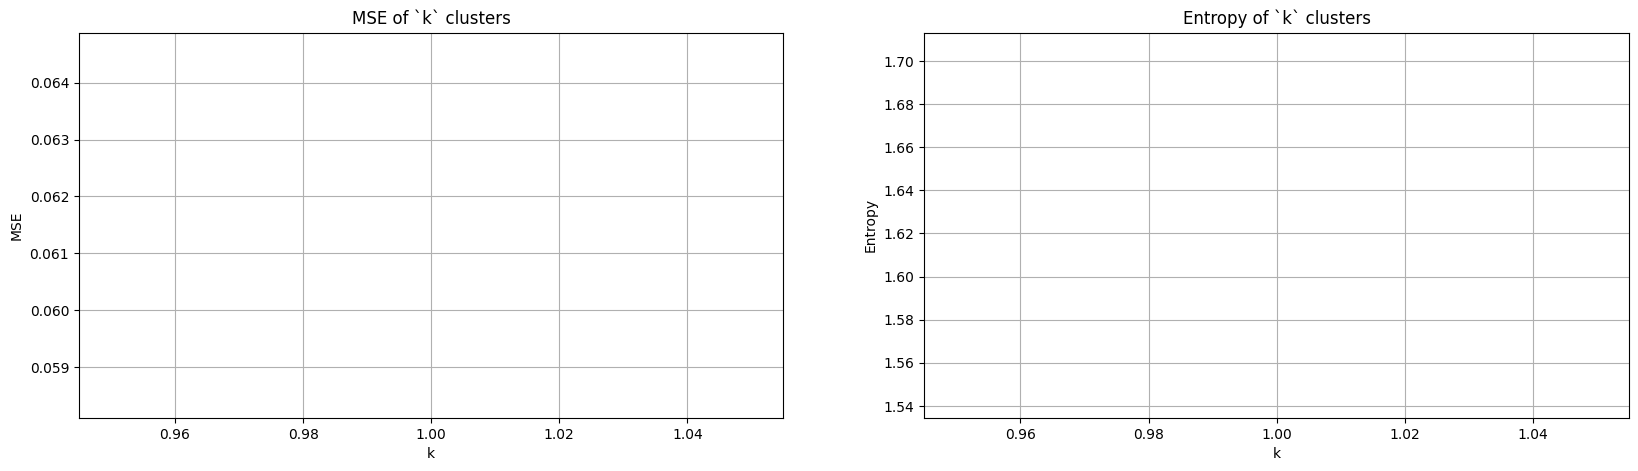

In [22]:
def plot_clustering_metrics(metrics_dict, fig_size=(20, 5)):
    """ Plot clustering metrics for different number of clusters. """
    # Number of metrics to plot
    n_metrics = len(metrics_dict)
    # Create plot for metrics
    fig = plt.figure(figsize=fig_size)

    for i, (metric_name, data) in enumerate(metrics_dict.items()):
        ax = fig.add_subplot(1, n_metrics, i+1)
        # Plot current metric on sub-plot
        ax.plot(np.arange(1, len(data)+1, dtype=int), data)

        # Title
        ax.set_title(f"{metric_name} of `k` clusters")
        # Axis labels
        ax.set_xlabel("k")
        ax.set_ylabel(metric_name)
        # Show grid
        ax.grid()

    # Show figure
    print(fig)

# Plot K-means MSE and clustering entropy
plot_clustering_metrics({
    "MSE": k_means_mse,
    "Entropy": k_means_entropy
})

The MSE plot does not show us anything useful, because MSE constantly decreases as the number of clusters increases. The overall entropy plot, on the other hand, gives us insights as we find $k = 4$ to be the local minimum of overall clustering entropy. This proves that partitioning samples into 4 clusters is a reasonable choice.

### Gaussian Mixture (Distribution-based Clustering)

Another popular clustering algorithm is Gaussian Mixture (GM) clustering, which utiltize **Gaussian mixture models**. A Gaussian mixture model is a mixture probability distribution consisting of several Gaussian distributions, each parameterized by mean $\mathbf{\mu}_i$ and variance $\mathbf{\Sigma}_i$. During training, we fit the Gaussian mixture model, such that its mixture proabability distribution matches the actual distribution of samples. This is done by iteratively performing **Expectation-Maximization (EM)**, which is somewhat similar to K-means:

* Expectation step (E step): compute the expected log likelihood of samples under the current mixture distribution.
* Maximization step (M step): maximize the expected log likelihood by adjusting distribution parameters.

When the EM algorithm converges, we compute the probability of all samples under each component Gaussian distribution. Then, the clustering category of a sample is determined by finding the Gaussian distribution under which the probability of the sample is the greatest.

In the following code cell, we run Gaussian Mixture clustering on raw `StandardScaler` features and t-SNE transformed `StandardScaler` features. We will set the number of clusters to 5. Again, we compute the confusion matrix for both clustering results, then visualize the clustering using for t-SNE transformed features:

Gaussian Mixture (Raw features) started...
Gaussian Mixture (Raw features) completed. Elapsed time: 1.09s

Gaussian Mixture (t-SNE) started...
Gaussian Mixture (t-SNE) completed. Elapsed time: 1.58s

Gaussian Mixture (t-SNE) started...
Gaussian Mixture (t-SNE) completed. Elapsed time: 1.12s

Confusion matrix of Gaussian Mixture on raw features:
 [[    2     0   271  4476     2]
 [13988  4353     0   199  1048]
 [    0     0     0     0     0]
 [    0     0     0     0     0]
 [    0     0     0     0     0]] 

Confusion matrix of Gaussian Mixture on autoencoder (AE-1) transformed features:
 [[    1     0  2115   843     0  1792]
 [13977  4231     0   361  1002    17]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]] 

Confusion matrix of Gaussian Mixture on enhanced autoencoder (AE-2) transformed features:
 [[    1  1631    97     0  2416   606]
 [13962     4  1004  4296   128   1

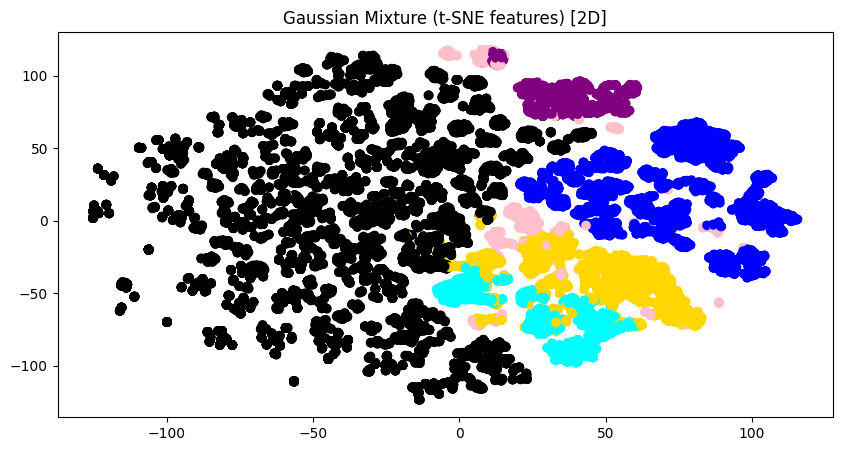

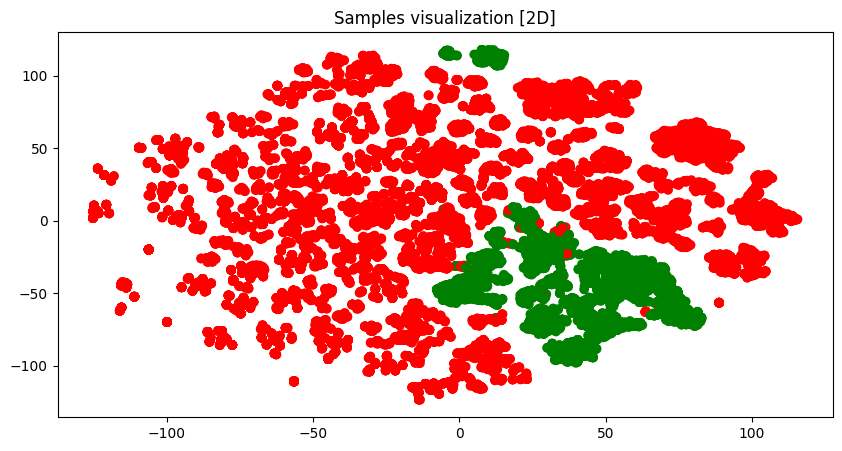

In [23]:
from sklearn.mixture import GaussianMixture

# Gaussian mixture clustering on raw `StandardScaler` features
# (Learn 4 clusters for all samples)
gm_std = GaussianMixture(n_components=5, random_state=87654321)
with timeit("Gaussian Mixture (Raw features)"):
    pred_gm_std = gm_std.fit_predict(kdd_feat_std)

print("")
# Gaussian mixture on autoencoder transformed `StandardScaler` features
gm_autoenc1 = GaussianMixture(n_components=6, random_state=87654321)
with timeit("Gaussian Mixture (t-SNE)"):
    pred_gm_autoenc1 = gm_autoenc1.fit_predict(kdd_feat_ae_1)

print("")

# Gaussian mixture on enhanced autoencoder transformed `StandardScaler` features
gm_autoenc2 = GaussianMixture(n_components=6, random_state=87654321)
with timeit("Gaussian Mixture (t-SNE)"):
    pred_gm_autoenc2 = gm_autoenc2.fit_predict(kdd_feat_ae_2)

print("")

# Confusion matrix of clustering results
print(
    "Confusion matrix of Gaussian Mixture on raw features:\n",
    confusion_matrix(y_std, pred_gm_std), "\n"
)
print(
    "Confusion matrix of Gaussian Mixture on autoencoder (AE-1) transformed features:\n",
    confusion_matrix(y_std, pred_gm_autoenc1), "\n"
)
print(
    "Confusion matrix of Gaussian Mixture on enhanced autoencoder (AE-2) transformed features:\n",
    confusion_matrix(y_std, pred_gm_autoenc2), "\n"
)

# Plot K-means clustering result for t-SNE transformed features
visualize_samples(
    kdd_feat_ae_2_tsne, pred_gm_autoenc2,
    title="Gaussian Mixture (t-SNE features)",
    colors=["black", "cyan", "purple", "blue", "gold","pink"]
)
visualize_samples(kdd_feat_ae_2_tsne, y_std)

Like K-means, we are interested in the best choice of number of clusters, so we compute and plot the overall clustering entropy for different number of clusters using the Gaussian Mixture clustering:

Running Gaussian Mixture for k = 5...
Running Gaussian Mixture for k = 10...
Running Gaussian Mixture for k = 15...
Figure(600x400)


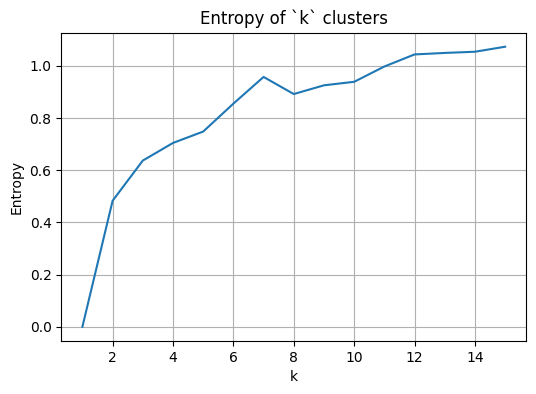

In [24]:
# Overall entropy for each `k` value
gm_entropy = []

# Maximal number of clusters to try
k_max = 15

for k in range(1, k_max+1):
    if k%5==0:
        print(f"Running Gaussian Mixture for k = {k}...")

    # Learn `k` clusters during gaussian mixture clustering
    gm_t_autoenc_try = GaussianMixture(n_components=k, random_state=87654321)
    # Cluster t-SNE transformed `StandardScaler` features
    pred_gm_autoenc_try = gm_t_autoenc_try.fit_predict(kdd_feat_ae_2)

    # Compute and store clustering entropy for `k`
    entropy_k = clustering_entropy(confusion_matrix(y_std, pred_gm_autoenc_try))
    gm_entropy.append(entropy_k)

# Plot overall clustering entropy for GM clustering results
plot_clustering_metrics({"Entropy": gm_entropy}, fig_size=(6, 4))

# 📝 Discussion Questions (Answer in this notebook)

> **Q1 (AE-2 + K-means): Choosing the number of clusters**  
> Using your **Entropy vs. k** plot for **K-means** on **AE-2 features**, justify the number of clusters **we chose** for AE-2.  
> In your justification, clearly refer to what you see in the plot.

> **Q2 (K-means): Best feature extraction method**  
> Using the **confusion matrices** you computed for **K-means**, decide which feature extraction method gives the best clustering results:  
> - raw standardized features (`kdd_feat_std`)  
> - AE-1 bottleneck features (`kdd_feat_ae_1`)  
> - AE-2 bottleneck features (`kdd_feat_ae_2`)  
> Explain your choice using specific patterns you observe in the confusion matrices.

> **Q3 (AE-2 + Gaussian Mixture): Choosing the number of clusters**  
> Using your **Entropy vs. k** plot for **Gaussian Mixture** on **AE-2 features**, justify the number of clusters **we chose** for AE-2.  
> Refer to what you see in the plot.

> **Q4 (Gaussian Mixture): Best feature extraction method**  
> Using the **confusion matrices** you computed for **Gaussian Mixture**, decide which feature extraction method gives the best clustering results:  
> - raw standardized features (`kdd_feat_std`)  
> - AE-1 bottleneck features (`kdd_feat_ae_1`)  
> - AE-2 bottleneck features (`kdd_feat_ae_2`)  
> Explain your choice using specific evidence from the confusion matrices.


Q1 (AE-2 + K-means): Choosing the number of clusters

From the Entropy vs. k plot for K-means on the AE-2 bottleneck features, the entropy decreases quickly at small values of k and then starts to level off. There is a noticeable “elbow” in the curve around the chosen k value. After that point, increasing k does not significantly reduce the entropy anymore.

This suggests that adding more clusters beyond that value does not meaningfully improve how well the clusters align with the true labels. In other words, the clustering structure becomes stable around that k. That’s why we selected that number of clusters — it balances lower entropy with model simplicity, instead of over-fragmenting the data into too many small clusters.

Q2 (K-means): Best feature extraction method

Looking at the confusion matrices for K-means, the AE-2 bottleneck features give the cleanest clustering structure. In the confusion matrix for AE-2, we can see stronger concentration of counts in specific rows/columns compared to the raw standardized features. The raw features show more mixing between true classes and predicted clusters, meaning K-means struggles to separate them in the original high-dimensional space.

AE-1 improves things slightly compared to raw features, but AE-2 performs the best. The clusters produced using AE-2 features show clearer grouping patterns and less overlap across true classes. This makes sense because AE-2 has higher capacity (larger hidden layer + dropout + L2 regularization), so it learns a more structured and compact representation before clustering.

Based on the confusion matrices, AE-2 bottleneck features provide the best clustering performance for K-means.

Q3 (AE-2 + Gaussian Mixture): Choosing the number of clusters

From the Entropy vs. k plot for Gaussian Mixture on AE-2 features, we again see entropy decreasing as k increases, but the rate of improvement slows down after a certain point. There is a region where the curve flattens, meaning that additional clusters do not significantly improve cluster purity.

We chose the number of clusters at the point where the entropy stops decreasing sharply. Beyond that, improvements are marginal and may indicate overfitting rather than meaningful structure. So the selected k captures most of the separable structure in the AE-2 feature space without unnecessarily increasing complexity.

Q4 (Gaussian Mixture): Best feature extraction method

From the confusion matrices for Gaussian Mixture, AE-2 again appears to produce the most structured clustering. The raw standardized features show more scattered assignments across clusters, meaning the Gaussian components overlap heavily in the original space.

AE-1 shows some improvement, but AE-2 has the most concentrated blocks in the confusion matrix. This indicates that the Gaussian Mixture model can better model class-specific distributions in the reduced AE-2 space.

Because AE-2 compresses the data into a lower-dimensional space while preserving meaningful structure (and reducing noise), it makes the Gaussian clusters more separable. Based on the confusion matrices, AE-2 provides the best feature extraction method for Gaussian Mixture as well.

## References

1. KDD Cup 1999 Dataset: https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
2. Autoencoder: https://en.wikipedia.org/wiki/Autoencoder
3. K-means clustering: https://en.wikipedia.org/wiki/K-means_clustering
4. Lloyd's algorithm: https://en.wikipedia.org/wiki/Lloyd%27s_algorithm
5. K-means++: https://en.wikipedia.org/wiki/K-means%2B%2B
6. Mixture model: https://en.wikipedia.org/wiki/Mixture_model
7. Expectation-Maximization (EM): https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm